<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gan tensorflow-addons -q
!rm -rf sample_data
!rm -rf checkpoints samples
!mkdir checkpoints samples

     |████████████████████████████████| 367 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 68.8 MB/s 


In [2]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding
from tensorflow.keras.layers import Wrapper, AveragePooling2D, LeakyReLU, BatchNormalization, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
from tqdm import tqdm 
import tensorflow_addons as tfa
# from tensorflow_addons.layers import SpectralNormalization //not working

from google.colab import drive, auth

print(tf.__version__)

2.9.2


In [3]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [4]:
#@title CONFIG

IMAGE_SIZE = 64
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
BATCH_SIZE = 32
EPOCHS = 200
LATENT_DIM = 120
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 10
SEED = 1
NUM_CLASSES = 100
TFRECORD_PATH = 'gs://brids-xarvel/*.tfrec'
SAMPLE_INTERVAL = 5

GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07

In [5]:
weight_initializer = tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02, seed=SEED
)
weight_regularizer = None
weight_regularizer_fully = None

In [6]:
#@title Dataset

def preprocess_image(img):
    return tf.cast(img, tf.float32) / 127.5 - 1.

def get_tfrecord_dataset(
    batch_size: int,
    tfrecord_path: str,
    is_training: bool,
    *,
    image_size: int,
):
    def parse_example(proto):
        features = {
          "image": tf.io.FixedLenFeature([], tf.string), 
          'height': tf.io.FixedLenFeature([], tf.int64),
          'width': tf.io.FixedLenFeature([], tf.int64),
          'channels': tf.io.FixedLenFeature([], tf.int64),
          'label_text': tf.io.FixedLenFeature([], tf.string), 
          'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
          'label_number': tf.io.FixedLenFeature([], tf.int64),
        }

        parsed = tf.io.parse_single_example(
            serialized=proto,
            features=features
        )

        image, label = parsed["image"], parsed["label_number"]
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (image_size, image_size))
    
        return image, label
    
    tfrecord_files = tf.io.gfile.glob(tfrecord_path)

    dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = dataset.map(parse_example)
    if is_training:
      dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True, seed=SEED)
      dataset = dataset.repeat()

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(lambda image, label: (preprocess_image(image), label))
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
   
    return dataset

train_dataset = get_tfrecord_dataset(
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=False
) 

In [7]:
#@title SpectralNormalization


class SpectralNormalization(Wrapper):
    """
    Attributes:
       layer: tensorflow keras layers (with kernel attribute)
    """

    def __init__(self, layer, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        """Build `Layer`"""

        if not self.layer.built:
            self.layer.build(input_shape)

            if not hasattr(self.layer, 'kernel'):
                raise ValueError(
                    '`SpectralNormalization` must wrap a layer that'
                    ' contains a `kernel` for weights')

            self.w = self.layer.kernel
            self.w_shape = self.w.shape.as_list()
            self.u = self.add_weight(
                shape=tuple([1, self.w_shape[-1]]),
                initializer=k.initializers.TruncatedNormal(stddev=0.02),
                name='sn_u',
                trainable=False,
                dtype=tf.float32)

        super(SpectralNormalization, self).build()

    @tf.function
    def call(self, inputs):
        """Call `Layer`"""
        # Recompute weights for each forward pass
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        """Generate normalized weights.
        This method will update the value of self.layer.kernel with the
        normalized value, so that the layer is ready for call().
        """
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        eps = 1e-12
        _u = tf.identity(self.u)
        
        _v = tf.matmul(_u, tf.transpose(w_reshaped))
        _v = _v / tf.maximum(tf.reduce_sum(_v**2)**0.5, eps)
        _u = tf.matmul(_v, w_reshaped)
        _u = _u / tf.maximum(tf.reduce_sum(_u**2)**0.5, eps)

        self.u.assign(_u)
        sigma = tf.matmul(tf.matmul(_v, w_reshaped), tf.transpose(_u))

        self.layer.kernel = self.w / sigma

    def compute_output_shape(self, input_shape):
        return tf.TensorShape(
            self.layer.compute_output_shape(input_shape).as_list())

In [8]:
#@title ConditionalBatchNormalization

class ConditionalBatchNormalization(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(ConditionalBatchNormalization, self).__init__(**kwargs)
    
  def build(self, input_shape):
    batch, height, width, channels = input_shape
   
    self.linear_gamma = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_gamma'))
    self.linear_beta = SpectralNormalization(tf.keras.layers.Dense(channels, 
			kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully,
			use_bias = False,
			name = 'linear_beta'))
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, x, c, training=False):
    x = self.batchnorm(x, training=training)
    gamma = self.linear_gamma(c, training=training)  
    beta = self.linear_beta(c, training=training)

    return x * gamma[:, None, None] + beta[:, None, None]  

In [9]:
#@title SelfAttention

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        in_channels = int(input_shape[-1])

        self.conv_theta =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_phi =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//8, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_g =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels//2, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.conv_attn =  SpectralNormalization(tf.keras.layers.Conv2D(padding='valid', kernel_size=1, filters=in_channels, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
        self.sigma = self.add_weight('sigma', shape=[], initializer=tf.zeros_initializer())

    def call(self, x, training=None):
        batch_size, h, w, in_channels = map(int, x.shape.as_list())
        location_num = h*w
        downsampled_num = location_num//4

        theta = self.conv_theta(x, training=training)
        theta = tf.reshape(theta, [batch_size, location_num, in_channels//8])

        phi = self.conv_phi(x, training=training)
        phi = tf.nn.max_pool(phi, ksize=[2, 2], strides=2, padding='VALID')
        phi = tf.reshape(phi, [batch_size, downsampled_num, in_channels//8])

        attn = tf.matmul(theta, phi, transpose_b=True)
        attn = tf.nn.softmax(attn)

        g = self.conv_g(x, training=training)
        g = tf.nn.max_pool(g, ksize=[2, 2], strides=2, padding='VALID')
        g = tf.reshape(g, [batch_size, downsampled_num, in_channels//2])

        attn_g = tf.matmul(attn, g)
        attn_g = tf.reshape(attn_g, [batch_size, h, w, in_channels//2])
        attn_g = self.conv_attn(attn_g, training=training)

        return x + self.sigma * attn_g

In [10]:
#@title DBlock

class DBlock(Model):
  def __init__(self, channels, downsample=True, preactivation=True):
    super(DBlock, self).__init__()
    self.out_channels = channels
    self.hidden_channels = self.out_channels 
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.hidden_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.av_pool_1 = AveragePooling2D(padding='same')
    self.av_pool_2 = AveragePooling2D(padding='same')
    
    self.downsample = downsample
    self.preactivation = preactivation
  
  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = True if (self.in_channels != self.out_channels) or self.downsample else False

    if self.learnable_sc:
      self.conv_sc = tfa.layers.SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))

  def shortcut(self, x, training=False):
    if self.preactivation:
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
      if self.downsample:
        x = self.av_pool_1(x)
    else:
      if self.downsample:
        x = self.av_pool_1(x)
      if self.learnable_sc:
        x = self.conv_sc(x, training=training)
    return x

  def call(self, x, training=False):
    if self.preactivation:
      h = self.activation1(x)
    else:
      h = x    

    h = self.conv33_1(h, training=training)
    h = self.conv33_2(self.activation2(h), training=training)

    if self.downsample:
      h = self.av_pool_2(h)     
        
    return h + self.shortcut(x, training=training)           


In [11]:
#@title GBlock

class GBlock(Model):
  def __init__(self, channels):
    super(GBlock, self).__init__()
    self.out_channels = channels
    self.bn1 = ConditionalBatchNormalization()
    self.bn2 = ConditionalBatchNormalization()
    self.up_sample_1 = UpSampling2D()
    self.up_sample_2 = UpSampling2D()
    self.activation1 = tf.keras.layers.ReLU()
    self.activation2 = tf.keras.layers.ReLU()
    self.conv33_1 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.conv33_2 = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.upsample = True

  def build(self, input_shape):
    batch, height, width, channels = input_shape
    self.in_channels = channels
    self.learnable_sc = self.in_channels != self.out_channels

    if self.learnable_sc:
      self.conv_sc = SpectralNormalization(Conv2D(filters=self.out_channels, kernel_size=1, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
      
  def call(self, x, label, training=False):
    h = self.activation1(self.bn1(x, label, training=training))
    if self.upsample:
      h = self.up_sample_1(h)
      x = self.up_sample_2(x)

    h = self.conv33_1(h, training=training)
    h = self.activation2(self.bn2(h, label, training=training))
    h = self.conv33_2(h, training=training)

    if self.learnable_sc:       
      x = self.conv_sc(x, training=training)

    return h + x

In [12]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size):
    super(Generator, self).__init__()
    self.channels = channels
    self.linear = SpectralNormalization(Dense(4 * 4 * 16 * channels, use_bias=False, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully))
    self.reshape = Reshape([4, 4, 16 * channels])

    self.res_block_1 = GBlock(16 * channels)
    self.res_block_2 = GBlock(16 * channels)
    self.res_block_3 = GBlock(8 * channels)
    self.attention = SelfAttention()
    self.res_block_4 = GBlock(4 * channels)

    self.embedding = Embedding(num_classes, embedding_size, embeddings_initializer=weight_initializer)

    self.bn = BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.conv = SpectralNormalization(Conv2D(filters=3, kernel_size=3, padding='same', kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer))
    self.concat = tf.keras.layers.Concatenate();

  @tf.function
  def call(self, z, label, training=False):    
    z_split = tf.split(z, num_or_size_splits=5, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1(x, conds[0], training=training)
    x = self.res_block_2(x, conds[1], training=training)
    x = self.res_block_3(x, conds[2], training=training)
    x = self.attention(x, training=training)
    x = self.res_block_4(x, conds[3], training=training)
    x = self.bn(x, training=training)
    x = self.activation(x)
    x = self.conv(x, training=training)
    return tf.nn.tanh(x)

In [13]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, channels, num_classes):
    super(Discriminator, self).__init__()
    self.res_block_1 = DBlock(1 * channels, downsample=True, preactivation=False)
    self.res_block_2 = DBlock(2 * channels, downsample=True, preactivation=True)
    self.res_block_3 = DBlock(4 * channels, downsample=True, preactivation=True)
    self.res_block_4 = DBlock(8 * channels, downsample=True, preactivation=True)
    self.attention = SelfAttention()
    self.res_block_5 = DBlock(16 * channels, downsample=False, preactivation=True)
    self.activation = tf.keras.layers.ReLU()
    self.embedding = Embedding(num_classes, 16 * channels, embeddings_initializer=weight_initializer)

    self.linear = SpectralNormalization(
       Dense(1, kernel_initializer=weight_initializer, kernel_regularizer=weight_regularizer_fully)
    )
  
  @tf.function
  def call(self, x, label, training=False):
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.activation(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [14]:
with strategy.scope():
  generator = Generator(64, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM)
  discriminator = Discriminator(64, num_classes=NUM_CLASSES)

In [15]:
per_replica_batch_size = BATCH_SIZE // strategy.num_replicas_in_sync

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_tfrecord_dataset(
    batch_size=per_replica_batch_size,
    image_size=IMAGE_SIZE,
    tfrecord_path=TFRECORD_PATH, 
    is_training=True
))

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_hinge_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor:
  L_D = -tf.reduce_mean(tf.minimum(0., -1.0 + logits_real)) - tf.reduce_mean(tf.minimum(0., -1.0 - logits_fake))

  return L_D    

def generator_hinge_loss(logits_fake: tf.Tensor) -> tf.Tensor:
    L_G = -tf.reduce_mean(logits_fake)
    return L_G  

In [17]:
with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  )
  discriminator_optimizer = tf.keras.optimizers.Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

In [81]:
fixed_noise = tf.random.truncated_normal((100, LATENT_DIM), stddev=1)

def sample_images(epoch, save=False):
  rows = 10
  cols = 10

  noise = fixed_noise

  labels = np.arange(0, 100)
  gen_imgs = generator(noise, labels)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols) # constrained_layout=True
  fig.subplots_adjust(
      wspace = 0.0,   # the amount of width reserved for blank space between subplots
      hspace = 0.0   # the amount of height reserved for white space between subplots
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * 10 + i])
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)
  else:
    plt.show()

def show_analytics(meta, save=False):
  history = meta['history']

  with plt.xkcd():
    fig, axs = plt.subplots(figsize=(10,10))
    plt.plot(history['gen_loss'], label='Generator loss')
    plt.plot(history['disc_loss'], label='Discriminator loss')
    plt.title('Learing process')
    
    plt.figtext(.7, .17, '\n'.join([
        'Epoch=%s' % meta['epoch'],
        "GEN_LR=%s" % GENERATOR_LR,
        'DISC_LR=%s' % DISCRIMINATOR_LR,
        'BATCH_SIZE=%s' % BATCH_SIZE
    ]))

    fig.legend();
    if save:
      fig.savefig(SAMPLES_DIR + '/analytics_at_epoch_{:04d}.png'.format(meta['epoch'])) 
      plt.close(fig)   

In [19]:
#@title train_step

with strategy.scope():
  d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
  g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

@tf.function
def train_step(iterator):
  """The step function for one training step."""

  def step_fn(inputs):
    """The computation to run on each TPU device."""
    images, labels = inputs
    noise = tf.random.normal([per_replica_batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, labels, training=True)
      gen_predictions = discriminator(generated_images, labels, training=True)
      real_predictions = discriminator(images, labels, training=True)
      disc_loss = discriminator_hinge_loss(real_predictions, gen_predictions)
      gen_loss = generator_hinge_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
      zip(gradients_of_discriminator, discriminator.trainable_weights)
    )
    
    d_loss_metric.update_state(disc_loss)
    g_loss_metric.update_state(gen_loss)
    
    return disc_loss, gen_loss

  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, gen_loss, axis=None)
  
  return disc_loss, gen_loss

In [20]:
#@title checkpoint
import json

with strategy.scope():
  current_epoch = tf.Variable(1);

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)

defaultMeta = {
    "history": {
        "disc_loss": [],
        "gen_loss": []
    },
    "epoch": 1
}
meta = defaultMeta

META_FILE = CHECKPOINT_DIR + '/meta.json'

def restore_checkpoint():
  try:
    with open(META_FILE) as f:
      meta = json.load(f)
  except:
    meta = defaultMeta
    pass
  
  status = checkpoint.restore(latest_checkpoint, options=local_device_option)
  return meta

def save_checkpoint():
  print('Saving checkpoint');

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

  with open(META_FILE, 'w') as f:
    json.dump(meta, f)
  
  checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
  checkpoint.save(file_prefix = checkpoint_prefix, options=local_device_option)

meta = restore_checkpoint();

(1, 64, 64, 3)


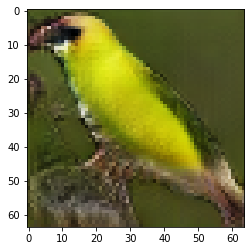

In [46]:
with strategy.scope():
  label = tf.constant([1])
  noise = tf.random.truncated_normal([1, 120], stddev=0.5)
  generated_image = generator(noise, label, training=False)
  print(generated_image.shape)
  plt.imshow(generated_image[0] * 0.5 + 0.5)  

In [47]:
with strategy.scope():
  decision = discriminator(generated_image, label)
  print(decision)

tf.Tensor([[-2.837654]], shape=(1, 1), dtype=float32)


In [23]:
steps_per_epoch = DATASET_SIZE // BATCH_SIZE
train_iterator = iter(train_dataset)

for epoch in range(meta['epoch'], EPOCHS):
  meta['epoch'] = epoch
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
    meta['history']['disc_loss'].append(float(disc_loss));
    meta['history']['gen_loss'].append(float(gen_loss));
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True)
    
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    show_analytics(meta, save=True)   

  print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

Epoch: 1/200


  0%|          | 0/414 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("PartitionedCall_1:2", shape=(4,), dtype=int64), values=Tensor("PartitionedCall_1:1", shape=(4, 120), dtype=float32), dense_shape=Tensor("PartitionedCall_1:3", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("concat_1:0", shape=(8,), dtype=int64), values=Tensor("concat:0", shape=(8, 1024), dtype=float32), dense_shape=Tensor("PartitionedCall_2:59", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % 

Time for epoch 2 is 301.12922835350037 sec
Epoch: 2/200


Current step 828: 100%|██████████| 414/414 [00:36<00:00, 11.41it/s, disc_loss=-, gen_loss=1.38]


Time for epoch 3 is 36.29968476295471 sec
Epoch: 3/200


Current step 1242: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.457, gen_loss=0.816]


Time for epoch 4 is 36.179229974746704 sec
Epoch: 4/200


Current step 1656: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.771, gen_loss=1.73]


Time for epoch 5 is 36.228333711624146 sec
Epoch: 5/200


Current step 2070: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.422, gen_loss=1.31]


Time for epoch 6 is 53.128453731536865 sec
Epoch: 6/200


Current step 2484: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.618, gen_loss=1.69]


Time for epoch 7 is 36.09529495239258 sec
Epoch: 7/200


Current step 2898: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.438, gen_loss=1.41]


Time for epoch 8 is 36.12291717529297 sec
Epoch: 8/200


Current step 3312: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.242, gen_loss=2.25]


Time for epoch 9 is 36.19310116767883 sec
Epoch: 9/200


Current step 3726: 100%|██████████| 414/414 [00:36<00:00, 11.41it/s, disc_loss=0.498, gen_loss=1.09]


Time for epoch 10 is 36.300599575042725 sec
Epoch: 10/200


Current step 4140: 100%|██████████| 414/414 [00:36<00:00, 11.40it/s, disc_loss=0.584, gen_loss=1.65]


Saving checkpoint
Time for epoch 11 is 56.1664514541626 sec
Epoch: 11/200


Current step 4554: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.842, gen_loss=0.389]


Time for epoch 12 is 36.116138219833374 sec
Epoch: 12/200


Current step 4968: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.822, gen_loss=0.502]


Time for epoch 13 is 36.21591377258301 sec
Epoch: 13/200


Current step 5382: 100%|██████████| 414/414 [00:36<00:00, 11.41it/s, disc_loss=0.832, gen_loss=2.06]


Time for epoch 14 is 36.28260636329651 sec
Epoch: 14/200


Current step 5796: 100%|██████████| 414/414 [00:36<00:00, 11.40it/s, disc_loss=0.533, gen_loss=1.88]


Time for epoch 15 is 36.315322160720825 sec
Epoch: 15/200


Current step 6210: 100%|██████████| 414/414 [00:36<00:00, 11.36it/s, disc_loss=0.427, gen_loss=1.11]


Time for epoch 16 is 53.45215344429016 sec
Epoch: 16/200


Current step 6624: 100%|██████████| 414/414 [00:36<00:00, 11.37it/s, disc_loss=0.535, gen_loss=1.64]


Time for epoch 17 is 36.43065071105957 sec
Epoch: 17/200


Current step 7038: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.279, gen_loss=2.07]


Time for epoch 18 is 36.22967457771301 sec
Epoch: 18/200


Current step 7452: 100%|██████████| 414/414 [00:36<00:00, 11.35it/s, disc_loss=0.336, gen_loss=1.65]


Time for epoch 19 is 36.484464168548584 sec
Epoch: 19/200


Current step 7866: 100%|██████████| 414/414 [00:36<00:00, 11.36it/s, disc_loss=0.248, gen_loss=1.83]


Time for epoch 20 is 36.44896721839905 sec
Epoch: 20/200


Current step 8280: 100%|██████████| 414/414 [00:36<00:00, 11.34it/s, disc_loss=0.556, gen_loss=2.63]


Saving checkpoint
Time for epoch 21 is 55.44955253601074 sec
Epoch: 21/200


Current step 8694: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.495, gen_loss=1.26]


Time for epoch 22 is 36.56565022468567 sec
Epoch: 22/200


Current step 9108: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.53, gen_loss=1.43]


Time for epoch 23 is 36.2165253162384 sec
Epoch: 23/200


Current step 9522: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.246, gen_loss=1.54]


Time for epoch 24 is 36.57123255729675 sec
Epoch: 24/200


Current step 9936: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.585, gen_loss=2.39]


Time for epoch 25 is 36.82197046279907 sec
Epoch: 25/200


Current step 10350: 100%|██████████| 414/414 [00:36<00:00, 11.23it/s, disc_loss=0.306, gen_loss=1.97]


Time for epoch 26 is 51.20319318771362 sec
Epoch: 26/200


Current step 10764: 100%|██████████| 414/414 [00:36<00:00, 11.31it/s, disc_loss=0.355, gen_loss=2.77]


Time for epoch 27 is 36.60494112968445 sec
Epoch: 27/200


Current step 11178: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.386, gen_loss=1.61]


Time for epoch 28 is 36.71252417564392 sec
Epoch: 28/200


Current step 11592: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.275, gen_loss=1.95]


Time for epoch 29 is 36.69894099235535 sec
Epoch: 29/200


Current step 12006: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.214, gen_loss=2.33]


Time for epoch 30 is 36.73953938484192 sec
Epoch: 30/200


Current step 12420: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.143, gen_loss=2.66]


Saving checkpoint
Time for epoch 31 is 56.19430422782898 sec
Epoch: 31/200


Current step 12834: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.462, gen_loss=2.89]


Time for epoch 32 is 36.70914840698242 sec
Epoch: 32/200


Current step 13248: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.543, gen_loss=1.14]


Time for epoch 33 is 36.84911513328552 sec
Epoch: 33/200


Current step 13662: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.278, gen_loss=1.57]


Time for epoch 34 is 36.7984504699707 sec
Epoch: 34/200


Current step 14076: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.49, gen_loss=2.51]


Time for epoch 35 is 36.77744221687317 sec
Epoch: 35/200


Current step 14490: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.702, gen_loss=0.764]


Time for epoch 36 is 53.10365962982178 sec
Epoch: 36/200


Current step 14904: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.168, gen_loss=2.54]


Time for epoch 37 is 36.73404932022095 sec
Epoch: 37/200


Current step 15318: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.523, gen_loss=1.45]


Time for epoch 38 is 36.73820376396179 sec
Epoch: 38/200


Current step 15732: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.403, gen_loss=1.04]


Time for epoch 39 is 36.71979546546936 sec
Epoch: 39/200


Current step 16146: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.334, gen_loss=1.54]


Time for epoch 40 is 36.730082273483276 sec
Epoch: 40/200


Current step 16560: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.212, gen_loss=1.88]


Saving checkpoint
Time for epoch 41 is 56.1969530582428 sec
Epoch: 41/200


Current step 16974: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.324, gen_loss=2.19]


Time for epoch 42 is 36.58010768890381 sec
Epoch: 42/200


Current step 17388: 100%|██████████| 414/414 [00:36<00:00, 11.33it/s, disc_loss=0.374, gen_loss=2.94]


Time for epoch 43 is 36.529911279678345 sec
Epoch: 43/200


Current step 17802: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.336, gen_loss=1.7]


Time for epoch 44 is 36.71838331222534 sec
Epoch: 44/200


Current step 18216: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.601, gen_loss=1.24]


Time for epoch 45 is 36.572548151016235 sec
Epoch: 45/200


Current step 18630: 100%|██████████| 414/414 [00:36<00:00, 11.34it/s, disc_loss=0.719, gen_loss=2.59]


Time for epoch 46 is 50.91332983970642 sec
Epoch: 46/200


Current step 19044: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.291, gen_loss=1.97]


Time for epoch 47 is 36.70453882217407 sec
Epoch: 47/200


Current step 19458: 100%|██████████| 414/414 [00:36<00:00, 11.19it/s, disc_loss=0.321, gen_loss=1.6]


Time for epoch 48 is 36.984962940216064 sec
Epoch: 48/200


Current step 19872: 100%|██████████| 414/414 [00:36<00:00, 11.27it/s, disc_loss=0.328, gen_loss=2.38]


Time for epoch 49 is 36.72509980201721 sec
Epoch: 49/200


Current step 20286: 100%|██████████| 414/414 [00:36<00:00, 11.23it/s, disc_loss=0.149, gen_loss=1.94]


Time for epoch 50 is 36.8682005405426 sec
Epoch: 50/200


Current step 20700: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.373, gen_loss=2.82]


Saving checkpoint
Time for epoch 51 is 56.44701600074768 sec
Epoch: 51/200


Current step 21114: 100%|██████████| 414/414 [00:36<00:00, 11.31it/s, disc_loss=0.641, gen_loss=0.759]


Time for epoch 52 is 36.60121488571167 sec
Epoch: 52/200


Current step 21528: 100%|██████████| 414/414 [00:36<00:00, 11.23it/s, disc_loss=0.344, gen_loss=2.84]


Time for epoch 53 is 36.874279499053955 sec
Epoch: 53/200


Current step 21942: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.2, gen_loss=2.68]


Time for epoch 54 is 36.759243965148926 sec
Epoch: 54/200


Current step 22356: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.597, gen_loss=1.11]


Time for epoch 55 is 36.62725830078125 sec
Epoch: 55/200


Current step 22770: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=1.7, gen_loss=3.02]


Time for epoch 56 is 51.2363440990448 sec
Epoch: 56/200


Current step 23184: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.178, gen_loss=2.54]


Time for epoch 57 is 36.82170629501343 sec
Epoch: 57/200


Current step 23598: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.222, gen_loss=2.35]


Time for epoch 58 is 36.6958327293396 sec
Epoch: 58/200


Current step 24012: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.109, gen_loss=2.09]


Time for epoch 59 is 36.67617344856262 sec
Epoch: 59/200


Current step 24426: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.649, gen_loss=0.992]


Time for epoch 60 is 36.673333406448364 sec
Epoch: 60/200


Current step 24840: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.335, gen_loss=1.49]


Saving checkpoint
Time for epoch 61 is 58.483954668045044 sec
Epoch: 61/200


Current step 25254: 100%|██████████| 414/414 [00:36<00:00, 11.31it/s, disc_loss=0.279, gen_loss=1.79]


Time for epoch 62 is 36.597477197647095 sec
Epoch: 62/200


Current step 25668: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.886, gen_loss=0.417]


Time for epoch 63 is 36.659658908843994 sec
Epoch: 63/200


Current step 26082: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.228, gen_loss=2.72]


Time for epoch 64 is 36.67804551124573 sec
Epoch: 64/200


Current step 26496: 100%|██████████| 414/414 [00:36<00:00, 11.19it/s, disc_loss=0.346, gen_loss=2.19]


Time for epoch 65 is 37.00287914276123 sec
Epoch: 65/200


Current step 26910: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.278, gen_loss=1.66]


Time for epoch 66 is 51.20731711387634 sec
Epoch: 66/200


Current step 27324: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.248, gen_loss=2.86]


Time for epoch 67 is 36.798941135406494 sec
Epoch: 67/200


Current step 27738: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.176, gen_loss=2.81]


Time for epoch 68 is 36.85166358947754 sec
Epoch: 68/200


Current step 28152: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.147, gen_loss=2.07]


Time for epoch 69 is 36.67800974845886 sec
Epoch: 69/200


Current step 28566: 100%|██████████| 414/414 [00:36<00:00, 11.24it/s, disc_loss=0.47, gen_loss=3.27]


Time for epoch 70 is 36.84013605117798 sec
Epoch: 70/200


Current step 28980: 100%|██████████| 414/414 [00:36<00:00, 11.21it/s, disc_loss=0.273, gen_loss=3.19]


Saving checkpoint
Time for epoch 71 is 56.39146566390991 sec
Epoch: 71/200


Current step 29394: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.246, gen_loss=2.33]


Time for epoch 72 is 36.63511419296265 sec
Epoch: 72/200


Current step 29808: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.377, gen_loss=3.28]


Time for epoch 73 is 36.78734993934631 sec
Epoch: 73/200


Current step 30222: 100%|██████████| 414/414 [00:36<00:00, 11.28it/s, disc_loss=0.201, gen_loss=2.16]


Time for epoch 74 is 36.70476007461548 sec
Epoch: 74/200


Current step 30636: 100%|██████████| 414/414 [00:36<00:00, 11.26it/s, disc_loss=0.499, gen_loss=1.6]


Time for epoch 75 is 36.76617431640625 sec
Epoch: 75/200


Current step 31050: 100%|██████████| 414/414 [00:36<00:00, 11.25it/s, disc_loss=0.151, gen_loss=2.49]


Time for epoch 76 is 51.247812032699585 sec
Epoch: 76/200


Current step 31464: 100%|██████████| 414/414 [00:36<00:00, 11.31it/s, disc_loss=0.174, gen_loss=2.24]


Time for epoch 77 is 36.601837396621704 sec
Epoch: 77/200


Current step 31878: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.207, gen_loss=2.82]


Time for epoch 78 is 36.650256395339966 sec
Epoch: 78/200


Current step 32292: 100%|██████████| 414/414 [00:36<00:00, 11.29it/s, disc_loss=0.274, gen_loss=2.01]


Time for epoch 79 is 36.658517599105835 sec
Epoch: 79/200


Current step 32706: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.322, gen_loss=3.56]


Time for epoch 80 is 36.63629221916199 sec
Epoch: 80/200


Current step 33120: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.47, gen_loss=1.14]


Saving checkpoint
Time for epoch 81 is 55.955862045288086 sec
Epoch: 81/200


Current step 33534: 100%|██████████| 414/414 [00:36<00:00, 11.30it/s, disc_loss=0.167, gen_loss=2.4]


Time for epoch 82 is 36.6557674407959 sec
Epoch: 82/200


Current step 33948: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.128, gen_loss=3.02]


Time for epoch 83 is 36.5644314289093 sec
Epoch: 83/200


Current step 34362: 100%|██████████| 414/414 [00:36<00:00, 11.37it/s, disc_loss=0.127, gen_loss=2.91]


Time for epoch 84 is 36.42146921157837 sec
Epoch: 84/200


Current step 34776: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.348, gen_loss=2.05]


Time for epoch 85 is 36.00854992866516 sec
Epoch: 85/200


Current step 35190: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.224, gen_loss=2.92]


Time for epoch 86 is 49.79747438430786 sec
Epoch: 86/200


Current step 35604: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.487, gen_loss=1.83]


Time for epoch 87 is 36.055158615112305 sec
Epoch: 87/200


Current step 36018: 100%|██████████| 414/414 [00:36<00:00, 11.39it/s, disc_loss=0.145, gen_loss=2.73]


Time for epoch 88 is 36.34423589706421 sec
Epoch: 88/200


Current step 36432: 100%|██████████| 414/414 [00:36<00:00, 11.42it/s, disc_loss=0.272, gen_loss=1.76]


Time for epoch 89 is 36.27018070220947 sec
Epoch: 89/200


Current step 36846: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.818, gen_loss=3.62]


Time for epoch 90 is 36.035680294036865 sec
Epoch: 90/200


Current step 37260: 100%|██████████| 414/414 [00:35<00:00, 11.55it/s, disc_loss=0.324, gen_loss=2.9]


Saving checkpoint
Time for epoch 91 is 54.9187695980072 sec
Epoch: 91/200


Current step 37674: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.196, gen_loss=3.24]


Time for epoch 92 is 35.910236120224 sec
Epoch: 92/200


Current step 38088: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.285, gen_loss=2.2]


Time for epoch 93 is 35.864930152893066 sec
Epoch: 93/200


Current step 38502: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.305, gen_loss=2.99]


Time for epoch 94 is 35.91163086891174 sec
Epoch: 94/200


Current step 38916: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.435, gen_loss=2.99]


Time for epoch 95 is 35.91794228553772 sec
Epoch: 95/200


Current step 39330: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.264, gen_loss=3.6]


Time for epoch 96 is 52.544337034225464 sec
Epoch: 96/200


Current step 39744: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.416, gen_loss=1.84]


Time for epoch 97 is 35.91391468048096 sec
Epoch: 97/200


Current step 40158: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.658, gen_loss=4.16]


Time for epoch 98 is 35.8936722278595 sec
Epoch: 98/200


Current step 40572: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.999, gen_loss=0.567]


Time for epoch 99 is 35.92643404006958 sec
Epoch: 99/200


Current step 40986: 100%|██████████| 414/414 [00:35<00:00, 11.56it/s, disc_loss=0.366, gen_loss=2.46]


Time for epoch 100 is 35.826931953430176 sec
Epoch: 100/200


Current step 41400: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.254, gen_loss=1.88]


Saving checkpoint
Time for epoch 101 is 54.880682706832886 sec
Epoch: 101/200


Current step 41814: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.183, gen_loss=1.89]


Time for epoch 102 is 35.936681509017944 sec
Epoch: 102/200


Current step 42228: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.373, gen_loss=2.47]


Time for epoch 103 is 35.97463846206665 sec
Epoch: 103/200


Current step 42642: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.41, gen_loss=1.52]


Time for epoch 104 is 36.031779766082764 sec
Epoch: 104/200


Current step 43056: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.0993, gen_loss=2.27]


Time for epoch 105 is 36.05066537857056 sec
Epoch: 105/200


Current step 43470: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.542, gen_loss=1.6]


Time for epoch 106 is 49.93535780906677 sec
Epoch: 106/200


Current step 43884: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.426, gen_loss=1.22]


Time for epoch 107 is 35.8711519241333 sec
Epoch: 107/200


Current step 44298: 100%|██████████| 414/414 [00:35<00:00, 11.50it/s, disc_loss=0.345, gen_loss=3.44]


Time for epoch 108 is 36.00226163864136 sec
Epoch: 108/200


Current step 44712: 100%|██████████| 414/414 [00:36<00:00, 11.45it/s, disc_loss=0.32, gen_loss=2.91]


Time for epoch 109 is 36.157896995544434 sec
Epoch: 109/200


Current step 45126: 100%|██████████| 414/414 [00:36<00:00, 11.45it/s, disc_loss=0.357, gen_loss=2.26]


Time for epoch 110 is 36.17884349822998 sec
Epoch: 110/200


Current step 45540: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.0812, gen_loss=2.63]


Saving checkpoint
Time for epoch 111 is 55.11872577667236 sec
Epoch: 111/200


Current step 45954: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.382, gen_loss=1.51]


Time for epoch 112 is 35.978941202163696 sec
Epoch: 112/200


Current step 46368: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.134, gen_loss=2.22]


Time for epoch 113 is 35.977176904678345 sec
Epoch: 113/200


Current step 46782: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.119, gen_loss=2.81]


Time for epoch 114 is 36.05376076698303 sec
Epoch: 114/200


Current step 47196: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.273, gen_loss=2.46]


Time for epoch 115 is 36.1157283782959 sec
Epoch: 115/200


Current step 47610: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.836, gen_loss=0.953]


Time for epoch 116 is 50.029967069625854 sec
Epoch: 116/200


Current step 48024: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.399, gen_loss=1.7]


Time for epoch 117 is 35.985562324523926 sec
Epoch: 117/200


Current step 48438: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.216, gen_loss=2.13]


Time for epoch 118 is 36.13449192047119 sec
Epoch: 118/200


Current step 48852: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=1.1, gen_loss=0.288]


Time for epoch 119 is 35.92766356468201 sec
Epoch: 119/200


Current step 49266: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.409, gen_loss=1.55]


Time for epoch 120 is 35.94313979148865 sec
Epoch: 120/200


Current step 49680: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.203, gen_loss=2.04]


Saving checkpoint
Time for epoch 121 is 54.78125762939453 sec
Epoch: 121/200


Current step 50094: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.676, gen_loss=3.45]


Time for epoch 122 is 35.87994146347046 sec
Epoch: 122/200


Current step 50508: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.271, gen_loss=2.97]


Time for epoch 123 is 35.90968132019043 sec
Epoch: 123/200


Current step 50922: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.405, gen_loss=2.99]


Time for epoch 124 is 35.89526128768921 sec
Epoch: 124/200


Current step 51336: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.179, gen_loss=2.14]


Time for epoch 125 is 36.18478488922119 sec
Epoch: 125/200


Current step 51750: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.303, gen_loss=1.69]


Time for epoch 126 is 49.60127019882202 sec
Epoch: 126/200


Current step 52164: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.16, gen_loss=2.27]


Time for epoch 127 is 36.03163027763367 sec
Epoch: 127/200


Current step 52578: 100%|██████████| 414/414 [00:36<00:00, 11.45it/s, disc_loss=0.475, gen_loss=2.51]


Time for epoch 128 is 36.175867795944214 sec
Epoch: 128/200


Current step 52992: 100%|██████████| 414/414 [00:36<00:00, 11.45it/s, disc_loss=0.328, gen_loss=2.6]


Time for epoch 129 is 36.17619585990906 sec
Epoch: 129/200


Current step 53406: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.292, gen_loss=2.75]


Time for epoch 130 is 35.898831367492676 sec
Epoch: 130/200


Current step 53820: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.405, gen_loss=1.3]


Saving checkpoint
Time for epoch 131 is 56.344958543777466 sec
Epoch: 131/200


Current step 54234: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.252, gen_loss=2.64]


Time for epoch 132 is 35.95875811576843 sec
Epoch: 132/200


Current step 54648: 100%|██████████| 414/414 [00:35<00:00, 11.55it/s, disc_loss=0.339, gen_loss=2.79]


Time for epoch 133 is 35.842636823654175 sec
Epoch: 133/200


Current step 55062: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.309, gen_loss=2.68]


Time for epoch 134 is 35.90876889228821 sec
Epoch: 134/200


Current step 55476: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.704, gen_loss=0.646]


Time for epoch 135 is 36.046873331069946 sec
Epoch: 135/200


Current step 55890: 100%|██████████| 414/414 [00:35<00:00, 11.50it/s, disc_loss=0.333, gen_loss=1.91]


Time for epoch 136 is 52.8955078125 sec
Epoch: 136/200


Current step 56304: 100%|██████████| 414/414 [00:35<00:00, 11.55it/s, disc_loss=0.133, gen_loss=2.48]


Time for epoch 137 is 35.841169357299805 sec
Epoch: 137/200


Current step 56718: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.472, gen_loss=2.76]


Time for epoch 138 is 35.90111041069031 sec
Epoch: 138/200


Current step 57132: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.374, gen_loss=1.87]


Time for epoch 139 is 36.073036670684814 sec
Epoch: 139/200


Current step 57546: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.382, gen_loss=1.43]


Time for epoch 140 is 36.20400142669678 sec
Epoch: 140/200


Current step 57960: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=1.02, gen_loss=3.15]


Saving checkpoint
Time for epoch 141 is 54.98598122596741 sec
Epoch: 141/200


Current step 58374: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.318, gen_loss=2.12]


Time for epoch 142 is 35.978477239608765 sec
Epoch: 142/200


Current step 58788: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.576, gen_loss=1.3]


Time for epoch 143 is 35.914350748062134 sec
Epoch: 143/200


Current step 59202: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.529, gen_loss=2.85]


Time for epoch 144 is 35.98154020309448 sec
Epoch: 144/200


Current step 59616: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.602, gen_loss=3.17]


Time for epoch 145 is 35.940224170684814 sec
Epoch: 145/200


Current step 60030: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.207, gen_loss=1.88]


Time for epoch 146 is 49.63641119003296 sec
Epoch: 146/200


Current step 60444: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.55, gen_loss=1.59]


Time for epoch 147 is 35.90367794036865 sec
Epoch: 147/200


Current step 60858: 100%|██████████| 414/414 [00:35<00:00, 11.50it/s, disc_loss=0.932, gen_loss=0.381]


Time for epoch 148 is 35.995118379592896 sec
Epoch: 148/200


Current step 61272: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.188, gen_loss=2.26]


Time for epoch 149 is 36.10952877998352 sec
Epoch: 149/200


Current step 61686: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.244, gen_loss=2.53]


Time for epoch 150 is 36.12708616256714 sec
Epoch: 150/200


Current step 62100: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.609, gen_loss=2.62]


Saving checkpoint
Time for epoch 151 is 55.46043419837952 sec
Epoch: 151/200


Current step 62514: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.77, gen_loss=0.659]


Time for epoch 152 is 36.00808262825012 sec
Epoch: 152/200


Current step 62928: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.148, gen_loss=2.67]


Time for epoch 153 is 35.9325156211853 sec
Epoch: 153/200


Current step 63342: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.558, gen_loss=2.03]


Time for epoch 154 is 36.11942982673645 sec
Epoch: 154/200


Current step 63756: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.203, gen_loss=2.56]


Time for epoch 155 is 35.97158169746399 sec
Epoch: 155/200


Current step 64170: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.432, gen_loss=3.16]


Time for epoch 156 is 50.12204885482788 sec
Epoch: 156/200


Current step 64584: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.277, gen_loss=2.56]


Time for epoch 157 is 36.03516459465027 sec
Epoch: 157/200


Current step 64998: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.382, gen_loss=1.9]


Time for epoch 158 is 36.06738471984863 sec
Epoch: 158/200


Current step 65412: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.542, gen_loss=1.25]


Time for epoch 159 is 35.91208052635193 sec
Epoch: 159/200


Current step 65826: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.375, gen_loss=2.53]


Time for epoch 160 is 35.984957218170166 sec
Epoch: 160/200


Current step 66240: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.497, gen_loss=1.42]


Saving checkpoint
Time for epoch 161 is 55.506794929504395 sec
Epoch: 161/200


Current step 66654: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.33, gen_loss=2.47]


Time for epoch 162 is 36.036860704422 sec
Epoch: 162/200


Current step 67068: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.445, gen_loss=1.08]


Time for epoch 163 is 35.95453429222107 sec
Epoch: 163/200


Current step 67482: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.37, gen_loss=2.89]


Time for epoch 164 is 36.00398564338684 sec
Epoch: 164/200


Current step 67896: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.326, gen_loss=2.07]


Time for epoch 165 is 36.07305407524109 sec
Epoch: 165/200


Current step 68310: 100%|██████████| 414/414 [00:36<00:00, 11.42it/s, disc_loss=0.797, gen_loss=0.971]


Time for epoch 166 is 50.18660855293274 sec
Epoch: 166/200


Current step 68724: 100%|██████████| 414/414 [00:36<00:00, 11.45it/s, disc_loss=0.344, gen_loss=1.9]


Time for epoch 167 is 36.15187430381775 sec
Epoch: 167/200


Current step 69138: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.717, gen_loss=0.813]


Time for epoch 168 is 36.108611822128296 sec
Epoch: 168/200


Current step 69552: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.429, gen_loss=1.51]


Time for epoch 169 is 36.11093473434448 sec
Epoch: 169/200


Current step 69966: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.173, gen_loss=1.95]


Time for epoch 170 is 36.11646342277527 sec
Epoch: 170/200


Current step 70380: 100%|██████████| 414/414 [00:36<00:00, 11.41it/s, disc_loss=0.286, gen_loss=1.48]


Saving checkpoint
Time for epoch 171 is 56.111711263656616 sec
Epoch: 171/200


Current step 70794: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.537, gen_loss=1.51]


Time for epoch 172 is 36.22713565826416 sec
Epoch: 172/200


Current step 71208: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.397, gen_loss=1.78]


Time for epoch 173 is 36.113171100616455 sec
Epoch: 173/200


Current step 71622: 100%|██████████| 414/414 [00:35<00:00, 11.51it/s, disc_loss=0.449, gen_loss=2.3]


Time for epoch 174 is 35.96445393562317 sec
Epoch: 174/200


Current step 72036: 100%|██████████| 414/414 [00:35<00:00, 11.50it/s, disc_loss=0.654, gen_loss=3.07]


Time for epoch 175 is 35.99625039100647 sec
Epoch: 175/200


Current step 72450: 100%|██████████| 414/414 [00:36<00:00, 11.46it/s, disc_loss=0.482, gen_loss=1.94]


Time for epoch 176 is 50.13792276382446 sec
Epoch: 176/200


Current step 72864: 100%|██████████| 414/414 [00:36<00:00, 11.45it/s, disc_loss=0.276, gen_loss=1.86]


Time for epoch 177 is 36.17451500892639 sec
Epoch: 177/200


Current step 73278: 100%|██████████| 414/414 [00:35<00:00, 11.54it/s, disc_loss=0.763, gen_loss=2.82]


Time for epoch 178 is 35.87204146385193 sec
Epoch: 178/200


Current step 73692: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.407, gen_loss=2.17]


Time for epoch 179 is 36.01038408279419 sec
Epoch: 179/200


Current step 74106: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.29, gen_loss=2.46]


Time for epoch 180 is 36.088836669921875 sec
Epoch: 180/200


Current step 74520: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=1.27, gen_loss=-.0406]


Saving checkpoint
Time for epoch 181 is 61.546398639678955 sec
Epoch: 181/200


Current step 74934: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.505, gen_loss=1.39]


Time for epoch 182 is 36.01216506958008 sec
Epoch: 182/200


Current step 75348: 100%|██████████| 414/414 [00:36<00:00, 11.43it/s, disc_loss=0.59, gen_loss=0.984]


Time for epoch 183 is 36.214884519577026 sec
Epoch: 183/200


Current step 75762: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.635, gen_loss=1.3]


Time for epoch 184 is 36.09384489059448 sec
Epoch: 184/200


Current step 76176: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.707, gen_loss=3.2]


Time for epoch 185 is 36.186885356903076 sec
Epoch: 185/200


Current step 76590: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.295, gen_loss=1.96]


Time for epoch 186 is 50.25753116607666 sec
Epoch: 186/200


Current step 77004: 100%|██████████| 414/414 [00:36<00:00, 11.49it/s, disc_loss=0.263, gen_loss=2.26]


Time for epoch 187 is 36.04983448982239 sec
Epoch: 187/200


Current step 77418: 100%|██████████| 414/414 [00:35<00:00, 11.52it/s, disc_loss=0.487, gen_loss=1.64]


Time for epoch 188 is 35.935084104537964 sec
Epoch: 188/200


Current step 77832: 100%|██████████| 414/414 [00:36<00:00, 11.44it/s, disc_loss=0.31, gen_loss=1.94]


Time for epoch 189 is 36.20406103134155 sec
Epoch: 189/200


Current step 78246: 100%|██████████| 414/414 [00:36<00:00, 11.36it/s, disc_loss=0.432, gen_loss=1.37]


Time for epoch 190 is 36.462589740753174 sec
Epoch: 190/200


Current step 78660: 100%|██████████| 414/414 [00:36<00:00, 11.35it/s, disc_loss=0.33, gen_loss=2.78]


Saving checkpoint
Time for epoch 191 is 56.393553018569946 sec
Epoch: 191/200


Current step 79074: 100%|██████████| 414/414 [00:36<00:00, 11.32it/s, disc_loss=0.368, gen_loss=1.31]


Time for epoch 192 is 36.57609295845032 sec
Epoch: 192/200


Current step 79488: 100%|██████████| 414/414 [00:36<00:00, 11.35it/s, disc_loss=0.133, gen_loss=2.34]


Time for epoch 193 is 36.49740695953369 sec
Epoch: 193/200


Current step 79902: 100%|██████████| 414/414 [00:36<00:00, 11.37it/s, disc_loss=0.338, gen_loss=1.76]


Time for epoch 194 is 36.40435981750488 sec
Epoch: 194/200


Current step 80316: 100%|██████████| 414/414 [00:36<00:00, 11.37it/s, disc_loss=0.371, gen_loss=2.16]


Time for epoch 195 is 36.42609167098999 sec
Epoch: 195/200


Current step 80730: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.413, gen_loss=2.96]


Time for epoch 196 is 49.875441789627075 sec
Epoch: 196/200


Current step 81144: 100%|██████████| 414/414 [00:36<00:00, 11.47it/s, disc_loss=0.356, gen_loss=2.73]


Time for epoch 197 is 36.094170570373535 sec
Epoch: 197/200


Current step 81558: 100%|██████████| 414/414 [00:36<00:00, 11.48it/s, disc_loss=0.409, gen_loss=3.34]


Time for epoch 198 is 36.08027458190918 sec
Epoch: 198/200


Current step 81972: 100%|██████████| 414/414 [00:36<00:00, 11.50it/s, disc_loss=0.377, gen_loss=1.91]


Time for epoch 199 is 36.01672339439392 sec
Epoch: 199/200


Current step 82386: 100%|██████████| 414/414 [00:35<00:00, 11.53it/s, disc_loss=0.678, gen_loss=3.1]

Time for epoch 200 is 35.91732573509216 sec


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


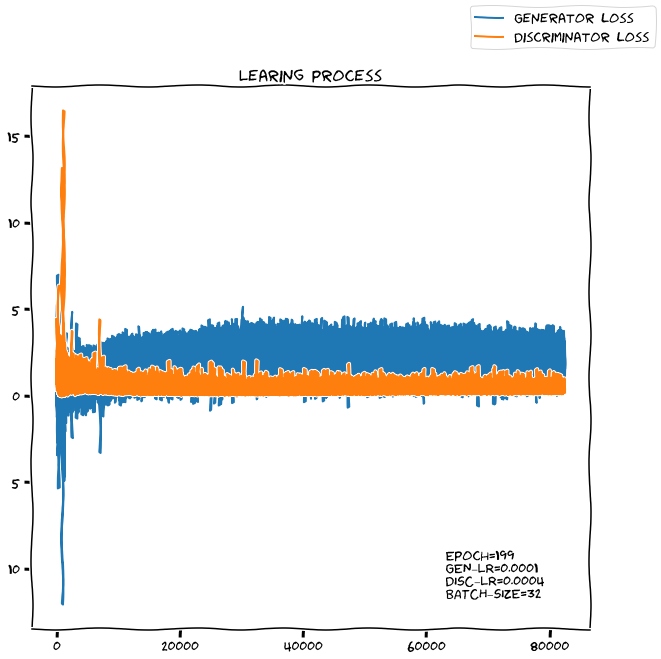

In [49]:
show_analytics(meta, save=False)    

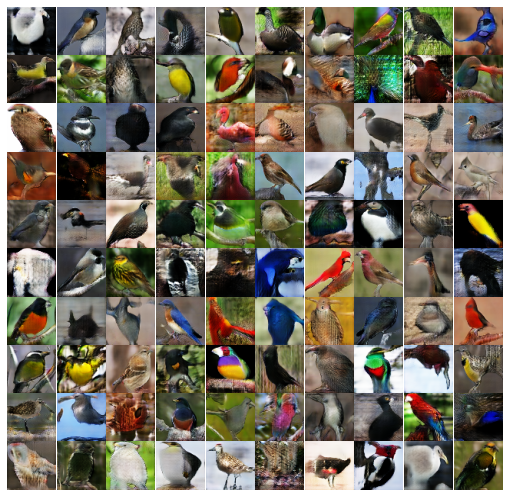

In [90]:
sample_images(meta['epoch'], save=False)